# **POTATO_Skin_Diseases_Detection_Using_Deep_Learning**

In [1]:
# %pip install tensorflow matplotlib

import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",  #Directory containing the dataset
    shuffle=True,  #Shuffle the dataset
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  #Resize images to 256x256 pixels
    batch_size=BATCH_SIZE  #Batch size for training
    )




Found 2152 files belonging to 3 classes.


1000+152+1000=2152 total images
#  **Dataset Structure**
```
PlantVillage/
├── Potato___Early_blight
│   ├── 0a1b2c3d.jpg
│   ├── 0a1b2c3e.jpg
│   └── ...
├── Potato___Late_blight
│   ├── 0a1b2c4d.jpg
│   ├── 0a1b2c4e.jpg
│   └── ...
└── Potato___healthy
    ├── 0a1b2c5d.jpg
    ├── 0a1b2c5e.jpg
    └── ...
```
#  **Dataset Information**
- **Total Images**: 2152
- **Classes**: 3 (Potato___Early_blight, Potato___Late_blight, Potato___healthy)
- **Image Size**: 256x256 pixels

3 Classes are the folder name

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32  # 2176 images in total last batch was not proper 
# 32 was Batch size

2176

**Explore data**

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 0 1 0 1 1 1 0 0 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 2 1]


(32, 256, 256, 3)


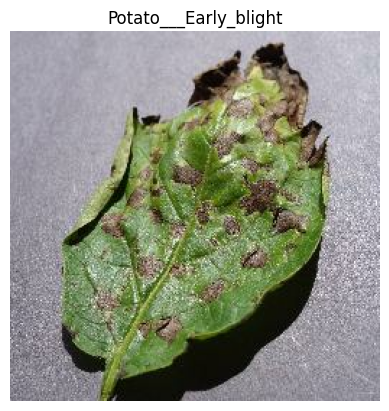

In [8]:
for image_batch, labels_batch in dataset.take(1):
    # print(image_batch[0]) # it will give image as a tensor
    # print(image_batch[0].numpy()) # it will give label as a numpy array
    print(image_batch.shape)  # (32, 256, 256, 3) 32 images of size 256x256 with 3 channels
    plt.imshow(image_batch[0].numpy().astype("uint8"))  # Display the first image
    plt.axis("off")  # Hide the axis
    plt.title(class_names[labels_batch[0]])  # Display the label of the first


# Display a batch of images


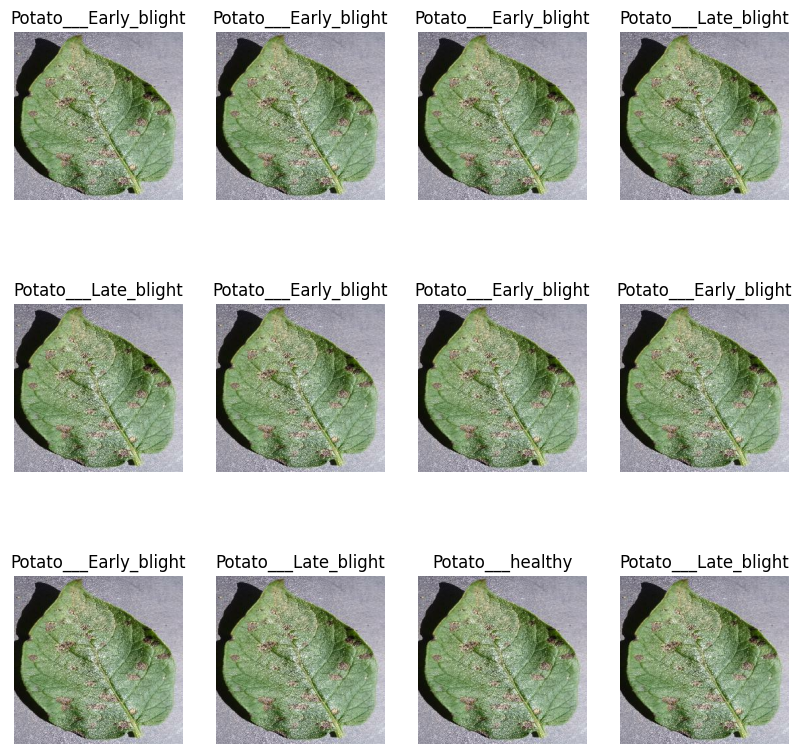

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[0].numpy().astype("uint8"))  
        plt.title(class_names[labels_batch[i]])  
        plt.axis("off")
        

# Split The dataset Into Test and Train

Validation and test datasets are 10% each, while the training dataset is 80%. With every epoch, the model will learn from the training dataset, validate its performance on the validation dataset, and finally test its accuracy on the test dataset.

After epoch we will use test dataset to check the accuracy of the model before the deploy.

**80% ==> training**

***20% ==> 10% ==> validation, 10% ==> test**

80% of 68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds=dataset.take(54)  # 54 batches for training
len(train_ds)  # 54 batches for training

54

For test and validation we will use 10% each

In [12]:
test_ds=dataset.skip(54)  # Skip the first 54 batches for validtion and test
len(test_ds)  # 14 batches for validation and test

14

In [13]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds=test_ds.take(6)  # 6 batches for validation
len(val_ds)  # 6 batches for validation

6

In [15]:
test_ds=test_ds.skip(6)  # 6 batches for validation
len(test_ds)

8

# Function to Split Dataset into Train, Test and Validation

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=1000):

    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

  
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds), len(val_ds), len(test_ds)

(54, 6, 8)

# Caching

for second iteration we will use the same dataset, so we will cache it to speed up the process. Data is in main memory.

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Pre-Processing

# 1. scaling

In [20]:
# resize_and_rescale = tf.keras.Sequential([
#     layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
#     layers.experimental.preprocessing.Rescaling(1.0/255)
    
# ])

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])


# DataAugmention 

for making model Robust

with diffferent angles, brightness, contrast, etc.

In [21]:
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2)
# ])

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])



# Build the model

We are using CNN for train the data

In [22]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE, input_shape=input_shape),
    tf.keras.layers.Rescaling(1.0/255),
    data_augmentation,   # Data augmentation

    # Apply 2D convolution (layers, kernel size, activation)
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)), # after CNN layer there is pooling layer max pooling or min #reduce size and preserve feature


    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3) , activation='relu' ),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes , activation='softmax')  # Output layer with softmax

])

model.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

c:\Users\PANDIT JI\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

# **layer-by-layer explanation**

---

### 🧱 Input Processing Layers

| Layer          | Type       | Output Shape        | Params | Explanation                                                                                |
| -------------- | ---------- | ------------------- | ------ | ------------------------------------------------------------------------------------------ |
| `resizing_1`   | Resizing   | (None, 256, 256, 3) | 0      | Resizes all input images to 256x256 with 3 channels (RGB). `None` is for batch size.       |
| `rescaling_1`  | Rescaling  | (None, 256, 256, 3) | 0      | Scales pixel values, usually dividing by 255 to normalize between 0 and 1.                 |
| `sequential_1` | Sequential | (None, 256, 256, 3) | 0      | This is likely your data augmentation block (e.g., flip, rotate). No trainable parameters. |

---

### 🧠 Convolutional Layers (Feature Extraction)

#### 🔄 Conv2D + Pooling Layers:

Each `Conv2D` layer learns features (edges, textures) using filters, and each `MaxPooling2D` reduces spatial size to control overfitting and improve efficiency.

| Layer              | Output Shape   | Params | Notes                                               |
| ------------------ | -------------- | ------ | --------------------------------------------------- |
| `conv2d_48`        | (254, 254, 32) | 896    | 32 filters, 3x3 kernel → **(3×3×3 + 1) × 32 = 896** |
| `max_pooling2d_48` | (127, 127, 32) | 0      | Downsamples by 2×                                   |
| `conv2d_49`        | (125, 125, 64) | 18,496 | **(3×3×32 + 1) × 64 = 18,496**                      |
| `max_pooling2d_49` | (62, 62, 64)   | 0      | Reduces spatial size                                |
| `conv2d_50`        | (60, 60, 64)   | 36,928 | Same formula, more input depth                      |
| `max_pooling2d_50` | (30, 30, 64)   | 0      | ↓                                                   |
| `conv2d_51`        | (28, 28, 64)   | 36,928 | ↓                                                   |
| `max_pooling2d_51` | (14, 14, 64)   | 0      | ↓                                                   |
| `conv2d_52`        | (12, 12, 64)   | 36,928 | ↓                                                   |
| `max_pooling2d_52` | (6, 6, 64)     | 0      | ↓                                                   |
| `conv2d_53`        | (4, 4, 64)     | 36,928 | ↓                                                   |
| `max_pooling2d_53` | (2, 2, 64)     | 0      | ↓                                                   |

---

### 🔢 Dense Layers (Classification)

| Layer       | Output Shape | Params | Explanation                                                               |
| ----------- | ------------ | ------ | ------------------------------------------------------------------------- |
| `flatten_7` | (256,)       | 0      | Flattens 2×2×64 into a 1D vector: 2×2×64 = 256                            |
| `dense_14`  | (64,)        | 16,448 | Fully connected layer: **(256×64) + 64 bias = 16,448**                    |
| `dense_15`  | (3,)         | 195    | Final output layer: **(64×3) + 3 bias = 195**, for 3-class classification |

---

### 📊 Summary

| Total Parameters | 183,747 |
| ---------------- | ------- |
| Trainable        | 183,747 |
| Non-trainable    | 0       |

---

### ✅ Final Output

* The final output is a **softmax vector of size 3**: each value represents the probability for each of the 3 classes.
* The shape `(None, 3)` means that for each input image, the model outputs 3 probabilities (summing to 1).

---


In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    epochs=EPOCHS ,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 398s 7s/step - accuracy: 0.4791 - loss: 0.9113 - val_accuracy: 0.6562 - val_loss: 0.8005
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 369s 7s/step - accuracy: 0.7526 - loss: 0.6467 - val_accuracy: 0.8021 - val_loss: 0.4521
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 386s 7s/step - accuracy: 0.8277 - loss: 0.4104 - val_accuracy: 0.8177 - val_loss: 0.3942
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 223s 4s/step - accuracy: 0.8588 - loss: 0.3839 - val_accuracy: 0.8281 - val_loss: 0.3899
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 487s 9s/step - accuracy: 0.8780 - loss: 0.2989 - val_accuracy: 0.9167 - val_loss: 0.1903
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 468s 9s/step - accuracy: 0.8886 - loss: 0.2556 - val_accuracy: 0.9115 - val_loss: 0.2137
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 574s 11s/step - accuracy: 0.9051 - loss: 0.2699 - val_accuracy: 0.9427 - val_loss: 0.1525
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 490s 9s/step - accuracy: 0.9299 - loss: 0.2087 - val_accuracy: 0.9479 - 

In [ ]:
scores = model.evalute(test_ds)

NameError: name 'model' is not defined

In [ ]:
scores

PLay With History

In [ ]:
history

Parameters

In [ ]:
history.params

it include with 4 parameters: loss, accuracy, val_loss, val_accuracy

In [ ]:
history.history.keys()

In [ ]:
len(history.history['accuracy'])  # we can plot these history values in chart

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

we can plot these history values in chart   

In [ ]:
plt.figure(figsize=(8, 8 ))
plt.subplot(1, 2, 1)

plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')


plt.figure(figsize=(8, 8 ))
plt.subplot(1, 2, 2)

plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


# Make a Prediction

In [ ]:
import numpy as np

In [ ]:
np.argmax()# output of nicche wale ka)

In [ ]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')  # Display the first image in the batch
    first_label = labels_batch[0]  # Get the label of the first image

    print("First image to predict: ")
    plt.imshow(first_image)
    print("First image's actual label: ", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    # print("Batch prediction: ", batch_prediction[0])
    # print(class_names[np.argmax(batch_prediction[0])])  # Display the predicted label for the first image
    print("Predicted label: ", class_names[np.argmax(batch_prediction[0])])

highest is actual class

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

In [ ]:
plt.figure (figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        # ax = plt.subplot(3, 4, i + 1)
        # plt.imshow(image_batch[i].numpy().astype("uint8"))
        # predicted_class, confidence = predict(model, image_batch)
        # plt.title(f"Predicted: {predicted_class} ({confidence}%)")
        # plt.axis("off")
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Predicted: {predicted_class} ({confidence}%)\nActual: {actual_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")




# Save The Models

# 1st version

In [ ]:
# model_version=1
# model.save(f"../models/{model_version}")

# 2nd version

In [ ]:
# model_version=1
# model.save(f"../models/{model_version}")

Automate Version and save the model

# Auto increment version number and models saved

In [ ]:
import os
model_version=max([ int (i) for i in os.listdir("../models/") + [0]]+1)
model.save(f"../models/{model_version}")
